<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [263]:
pip install sklearn-lvq

In [264]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn_lvq import GlvqModel
from sklearn_lvq.utils import plot2d
from sklearn.mixture import GaussianMixture
from statsmodels.graphics.tsaplots import plot_acf
import pandas as pd
import statsmodels.api as sm
from sklearn_lvq import GlvqModel
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import math

In [265]:
#Para acomodar la información si viene por minuto y en registros, 
#df = pd.read_csv('rg1.csv')
## aqui agrupamos por minuto
#df_grouped_multiple = df.groupby(['YEAR','MONTH','DAY','HOUR']).agg({'RG1': ['mean']})
#df_grouped_multiple.columns = ['rg1_mean']
#df_grouped_multiple = df_grouped_multiple.reset_index()
## aquí pivoteamos
#df1 = df_grouped_multiple.pivot(index=['YEAR','MONTH','DAY'], columns='HOUR', values='rg1_mean').dropna()
#print(df1) #df1.to_csv('res.csv')
#df1.columns = [['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17', '18','19', '20', '21', '22', '23']]

In [266]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie(serie_,title_,dot_):
    fig, ax1 = plt.subplots(figsize=(7,4))
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('horas', color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('radiación solar', color=LETRASNARA, fontsize='large')
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)    
    for p in serie_:
        if dot_== True:
           plt.plot(p,alpha=0.4, linestyle='dashed', linewidth=3)
        else:
           plt.plot(p,alpha=0.4)              
    plt.show()

In [267]:
def scatterplot(X_,Y_,tags_,centers_,title_,namefile_ ):
    fig, ax1 = plt.subplots(figsize=(4,4))
    CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
    for k in centers_:
        x = k[7]; y = k[8]
        plt.plot(x,y,"o",color="red",)
    plt.title(title_,fontsize='x-large',color=LETRASNARA)
    ax1.set_xlabel('hora 7',  color=LETRASNARA, fontsize='large')
    ax1.set_ylabel('hora 8',  color=LETRASNARA, fontsize='large')
    plt.scatter(X_, Y_, c=tags_, alpha=0.3)
    plt.tick_params(colors = LETRASNARA, which='both')
    ax1.spines['bottom'].set_color(LETRASNARA)
    ax1.spines['top'   ].set_color(LETRASNARA) 
    ax1.spines['right' ].set_color(LETRASNARA)
    ax1.spines['left'  ].set_color(LETRASNARA)
    plt.savefig(namefile_, transparent=True)
    plt.show()

   YEAR  MONTH  DAY  0  1  2  3    4    5    6  ...        17   18   19   20  \
0  2018      1    1  0  0  0  0  0.0  0.0  0.0  ...  0.000000  0.0  0.0  0.0   
1  2018      1    2  0  0  0  0  0.0  0.0  0.0  ...  0.000000  0.0  0.0  0.0   
2  2018      1    3  0  0  0  0  0.0  0.0  0.0  ...  0.000000  0.0  0.0  0.0   
3  2018      1    4  0  0  0  0  0.0  0.0  0.0  ...  0.000000  0.0  0.0  0.0   
4  2018      1    5  0  0  0  0  0.0  0.0  0.0  ...  0.033333  0.0  0.0  0.0   

   21  22  23         SUMA        dSUMA   ddSUMA  
0   0   0   0  1942.683333 -1613.866667  1773.45  
1   0   0   0   328.816667 -1613.866667  1773.45  
2   0   0   0   488.400000   159.583333  1773.45  
3   0   0   0  1801.133333  1312.733333  1153.15  
4   0   0   0  1174.666667  -626.466667 -1939.20  

[5 rows x 30 columns]


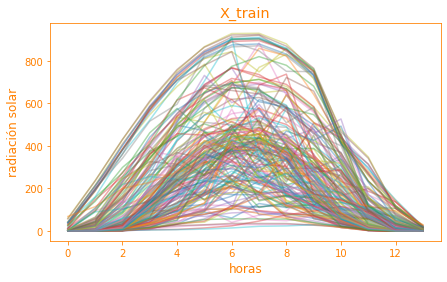

In [268]:
df = pd.read_csv('rg1_horas.csv')
df = df[(df.MONTH==11)|(df.MONTH==12)|(df.MONTH==1)|(df.MONTH==2)|(df.MONTH==3)|(df.MONTH==4)]
print(df.head())
horas_ = ['5','6','7','8','9','10','11','12','13','14','15','16','17','18']
X = df[horas_].to_numpy()
x_total   = df[['SUMA']].to_numpy()
dx_total  = df[['dSUMA']].to_numpy()
ddx_total = df[['ddSUMA']].to_numpy()

#Normalizing the data
#sc = StandardScaler()
#X  = sc.fit_transform(X)
#y  = sc.fit_transform(Y)

## Crea conjuntos de datos de entrenamiento y prueba
X_train, X_test = train_test_split(X, test_size=.5)#

print_serie(X_train,'X_train',False)
#print_serie(X_test,'X_test')

# **K-means**


[1 7 7 8 1 5 7 2 2 6 2 3 3 3 0 6 1 8 2 8 2 4 6 2 8 4 7 2 7 6 1 4 7 8 8 8 1
 7 1 6 2 2 3 0 3 8 0 3 3 8 8 7 1 3 8 1 7 6 6 2 3 1 6 7 8 6 3 8 1 2 8 7 2 2
 6 6 0 3 0 6 8 3 6 6 8 6 5 8 6 5 6 6 1 5 5 7 7 8 1 4 8 8 4 7 5 3 7 2 4 5 5
 3 8 2 2 2 8 3 8 2 3 8 2 3 3 3 1 1 3 8 1 6 4 8 6 8 5 4 0 6 6 7 8 2 6 7 6 8
 1 3 7 3 3 1 2 5 2 3 5 4 6 3 6 8 8 8 0 6 1 5 3 3 6 8 6 2 3 2 0 7]


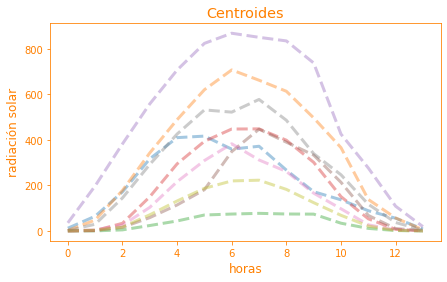

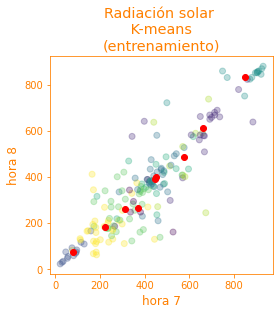

In [269]:
n_clusters = 9

k_means = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10) # una variante MiniBatchKMeans  
k_means = k_means.fit(X_train)
values  = k_means.cluster_centers_.squeeze()
labels  = k_means.labels_
centers_= k_means.cluster_centers_
#print('Centroides', centers_)
#print('Exactitud:', k_means.score(X_test))
y_pred = k_means.predict(X_test)
print(y_pred)
print_serie(centers_,'Centroides',True)
scatterplot(X_train[:,7],X_train[:,8],labels,centers_,'Radiación solar \n K-means \n(entrenamiento)','fig_t13_train')

# **LVQ**

In [270]:
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_rslvq.html
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/index.html
#https://mrnuggelz.github.io/sklearn-lvq/modules/generated/sklearn_lvq.GlvqModel.html#sklearn_lvq.GlvqModel
#https://mrnuggelz.github.io/sklearn-lvq/auto_examples/plot_glvq.html#sphx-glr-auto-examples-plot-glvq-py

print('GLVQ:')
glvq = GlvqModel(prototypes_per_class=5, initial_prototypes=None)
glvq.fit(X_train,labels)
glvq_pred = glvq.predict(X_test)
print(glvq_pred)
print('classification accuracy:', glvq.score(X_test, glvq_pred))
plt.show()

GLVQ:
[1 7 7 8 1 5 7 2 2 6 2 7 3 3 0 6 1 8 2 8 2 4 6 2 8 4 7 2 7 6 1 4 7 8 8 8 1
 7 1 6 2 2 3 0 3 8 0 3 3 8 8 7 1 3 8 1 3 6 6 2 0 1 6 7 8 6 3 8 1 2 8 3 2 2
 6 6 0 3 0 6 8 3 6 6 8 3 5 8 6 5 6 6 1 6 5 3 1 8 1 4 8 8 4 7 5 3 7 2 4 5 5
 3 8 2 2 2 8 3 8 2 3 8 2 3 3 3 1 1 3 8 1 6 4 8 6 8 5 4 7 6 6 0 8 2 6 7 6 8
 1 3 3 3 3 1 2 8 2 0 5 4 6 3 6 8 8 8 0 6 1 5 3 3 6 8 6 2 3 2 0 3]
classification accuracy: 1.0


[0 1 2 3 4 5 6 7 8]


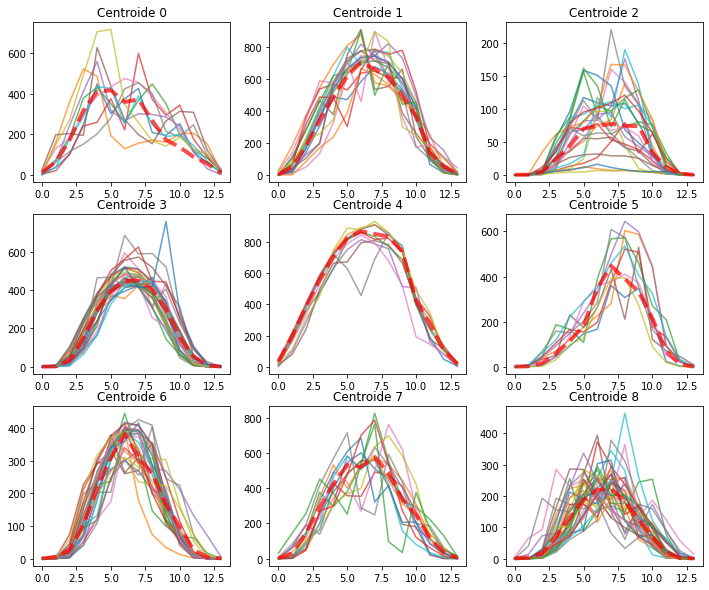

In [271]:
cat = np.unique(glvq_pred)
print(cat)
n = math.ceil(pow(n_clusters, 0.5))
fig, axs = plt.subplots(n, n, figsize=(12,10))
row=0
col=0

for c in cat:
    j = 0
    for g in glvq_pred:    
        if c == g:
            axs[row,col].plot(X_test[j],alpha=0.7)
            axs[row,col].set_title('Centroide '+str(c))
        j = j + 1
    axs[row, col].plot(centers_[c],alpha=0.7,color='red', linestyle='dashed', linewidth =4)
    col = col+1
    if col==n:
        col=0
        row=row+1  
plt.show()    

[0 1 2 3 4 5 6 7 8]


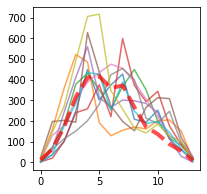

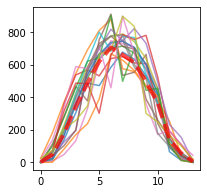

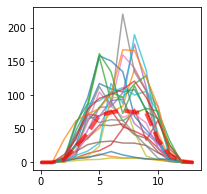

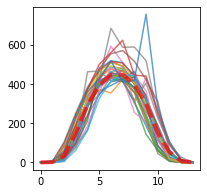

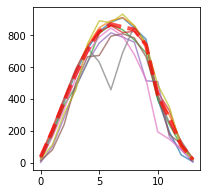

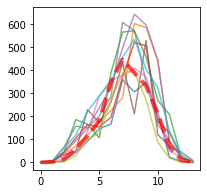

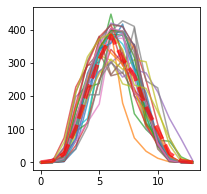

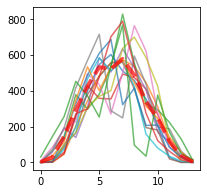

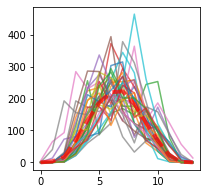

In [272]:
cat = np.unique(glvq_pred)
print(cat)

for c in cat:
    plt.figure(figsize=(3, 3))
    j = 0
    for g in glvq_pred:    
        if c == g:
            plt.plot(X_test[j],alpha=0.7)            
        j = j + 1
    plt.plot(centers_[c],alpha=0.7,color='red', linestyle='dashed', linewidth =4)
    plt.show()  

# **GaussianMixture**

In [273]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py
#https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
# fit a Gaussian Mixture Model with two components
gm = GaussianMixture(n_components=n_clusters, init_params='kmeans',covariance_type='diag') #full, tied, diag, spherical
gm.fit(X_train)

print(gm.predict(X_test))
gm_pred = gm.predict(X_test)
print('classification accuracy:', gm.score(X_test, gm_pred))


[5 7 7 2 6 7 6 4 7 4 4 6 7 7 0 4 5 4 8 7 4 3 7 4 4 3 6 4 7 7 6 3 6 4 4 0 5
 6 6 7 4 4 7 6 7 4 6 7 7 4 4 6 6 7 4 5 6 7 4 4 6 5 4 7 4 4 7 4 6 4 4 7 8 7
 4 4 6 7 6 4 2 4 4 4 4 7 2 4 2 7 4 7 5 7 2 7 6 4 6 3 4 4 6 6 2 7 6 4 6 2 2
 7 7 4 8 4 4 7 4 7 7 4 8 7 7 4 6 6 7 4 6 7 6 7 4 4 2 3 6 4 7 6 2 4 4 6 7 7
 6 7 7 7 7 6 8 7 7 6 4 3 4 7 4 7 4 4 6 4 6 2 2 7 4 7 7 4 7 7 0 2]
classification accuracy: -58.40739694360182


[0 2 3 4 5 6 7 8]


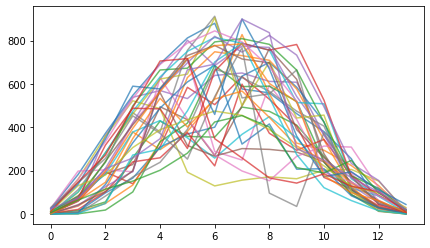

In [274]:
uni = np.unique(gm_pred)
print(uni)
plt.figure(figsize=(7, 4))
j=0
for i in gm_pred:
    if i==6:
      plt.plot(X_test[j],alpha=0.7)
    j = j + 1
plt.show()

# **KNN**

In [275]:
#https://scikit-learn.org/stable/modules/neighbors.html#classification
nbrs = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(X_train)  #['auto','ball_tree','kd_tree','brute'].
distances, indices = nbrs.kneighbors(X_train)
print(distances, indices)
nbrs.kneighbors_graph(X_train).toarray()

[[  0.          84.23622045 106.10089539 109.67201359 112.69283354]
 [  0.          91.01619666 109.35452667 110.76685727 116.6179386 ]
 [  0.         226.87379629 238.63400437 253.92956041 259.19640231]
 [  0.         264.6502099  301.74143459 308.09800031 310.84783259]
 [  0.         192.15434839 213.64679121 272.4254266  308.83344626]
 [  0.          59.45143438  77.38661776  90.58196411 113.99698455]
 [  0.          84.09946657 113.9559174  123.15544946 124.6691031 ]
 [  0.          68.82138717  81.53473865  86.95108138  95.57337352]
 [  0.         139.26576311 160.87530109 171.88553036 185.10552844]
 [  0.          80.95820593 112.86995836 113.9559174  118.64836943]
 [  0.          89.31991816  93.21613324  99.11817166 106.36380831]
 [  0.         165.38967029 215.7646165  215.79275422 225.82202991]
 [  0.          93.14616204 117.01638174 135.47399302 138.81514888]
 [  0.          64.50305337  91.27065516 111.28710868 114.07934248]
 [  0.          47.61661414  54.26690722  64.194

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [276]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, labels)
knn_pred = knn.predict(X_test)
print(knn_pred)
#print(knn.predict_proba(X_test))
knn.score(X_test,knn_pred)

[1 3 3 8 1 5 1 2 2 6 2 3 3 3 0 6 1 8 2 8 2 4 6 2 6 4 3 2 7 3 1 4 7 8 8 8 1
 7 1 6 2 2 3 0 3 8 0 3 3 8 8 5 1 3 8 1 3 6 6 2 0 1 6 3 8 6 3 8 1 2 8 3 2 2
 6 6 0 3 0 6 8 3 6 6 8 3 5 8 6 5 6 5 1 6 3 3 3 8 1 4 8 8 1 1 5 3 7 2 1 3 5
 3 8 2 2 2 8 3 8 2 3 8 2 3 3 3 1 1 3 8 1 6 1 8 6 8 3 4 0 6 6 0 8 2 6 7 6 8
 1 3 3 3 3 1 2 6 2 5 5 4 6 3 6 8 8 8 0 6 1 3 3 3 6 8 3 2 3 2 0 7]


1.0

[0 1 2 3 4 5 6 7 8]


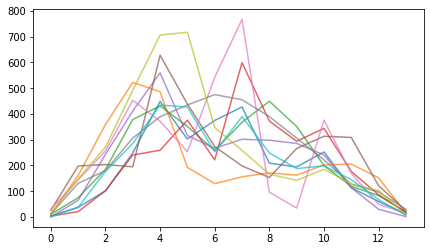

In [277]:
uni = np.unique(knn_pred)
print(uni)
plt.figure(figsize=(7, 4))
j=0
for i in knn_pred:
    if i==0:
      plt.plot(X_test[j],alpha=0.7)
    j = j + 1
plt.show()

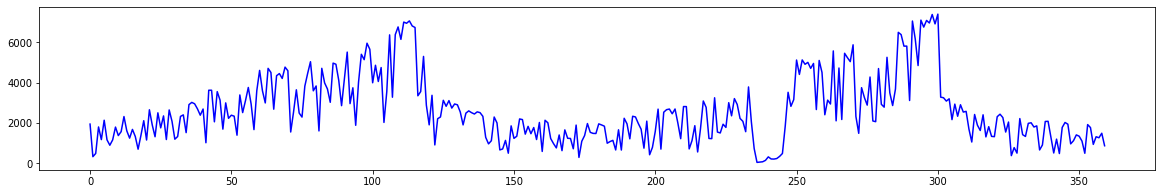

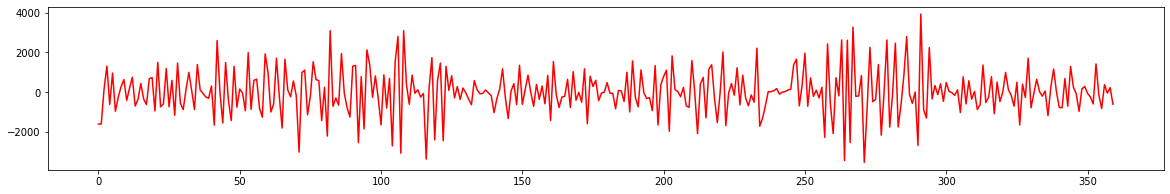

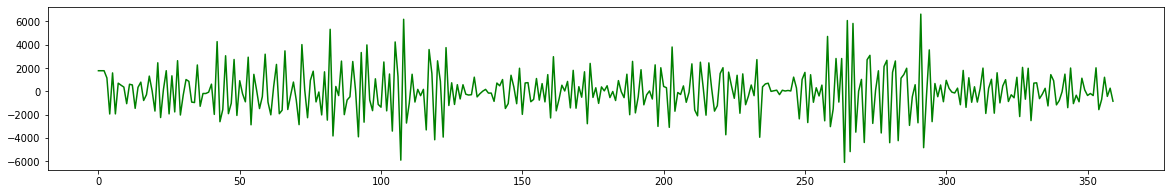

<Figure size 1440x216 with 0 Axes>

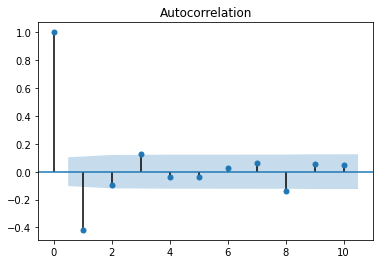

<Figure size 1440x216 with 0 Axes>

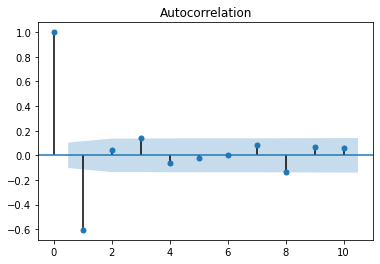

In [278]:
plt.figure(figsize=(20, 3))
plt.plot(x_total,alpha=1,color='blue')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(dx_total,alpha=1,color='red')
plt.show()
plt.figure(figsize=(20, 3))
plt.plot(ddx_total,alpha=1,color='green')
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(dx_total, lags=10)
plt.show()
plt.figure(figsize=(20, 3))
sm.graphics.tsa.plot_acf(ddx_total, lags=10)
plt.show()